In [40]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, plot_precision_recall_curve

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/kaggle/input/nlpgettingstarted/sample_submission.csv
/kaggle/input/nlpgettingstarted/train.csv
/kaggle/input/nlpgettingstarted/test.csv


In [41]:
df_train = pd.read_csv("/kaggle/input/nlpgettingstarted/train.csv")
df_test = pd.read_csv("/kaggle/input/nlpgettingstarted/test.csv")

In [42]:
df_train = df_train.drop(['keyword', 'location', 'id'], axis = 1)

In [43]:
train_df, test_df = train_test_split(df_train, test_size=500)

In [44]:
stop_words = stopwords.words("english")
snowball = SnowballStemmer(language="english")

def tokenize_sentence (sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="english")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [45]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words = True))

In [46]:
features = vectorizer.fit_transform(train_df["text"])

In [47]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df["target"])

LogisticRegression(random_state=0)

In [48]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ("model", LogisticRegression(random_state=0))
])
model_pipeline.fit(train_df["text"], train_df["target"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7ec1cf424320>)),
                ('model', LogisticRegression(random_state=0))])

In [49]:
precision_score(y_true=test_df["target"], y_pred=model_pipeline.predict(test_df["text"]))

0.8387096774193549

In [50]:
recall_score(y_true=test_df["target"], y_pred=model_pipeline.predict(test_df["text"]))

0.6632653061224489

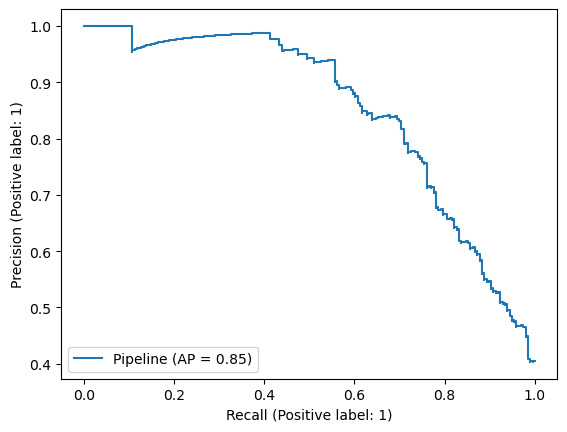

In [51]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["text"], y=test_df["target"])

In [52]:
model_grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ("model", 
     GridSearchCV(
         LogisticRegression(random_state=0),
         param_grid={'C' : [2, 2.1, 2.2]},
                    cv=5,
                    verbose=4))
])
model_grid_pipeline.fit(train_df["text"], train_df["target"])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...............................C=2;, score=0.791 total time=   0.2s
[CV 2/5] END ...............................C=2;, score=0.804 total time=   0.5s
[CV 3/5] END ...............................C=2;, score=0.805 total time=   0.2s
[CV 4/5] END ...............................C=2;, score=0.793 total time=   0.2s
[CV 5/5] END ...............................C=2;, score=0.790 total time=   0.3s
[CV 1/5] END .............................C=2.1;, score=0.789 total time=   0.4s
[CV 2/5] END .............................C=2.1;, score=0.805 total time=   0.5s
[CV 3/5] END .............................C=2.1;, score=0.804 total time=   0.4s
[CV 4/5] END .............................C=2.1;, score=0.793 total time=   0.4s
[CV 5/5] END .............................C=2.1;, score=0.790 total time=   0.2s
[CV 1/5] END .............................C=2.2;, score=0.789 total time=   0.3s
[CV 2/5] END .............................C=2.2;,

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7ec1c52e7e60>)),
                ('model',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [2, 2.1, 2.2]}, verbose=4))])

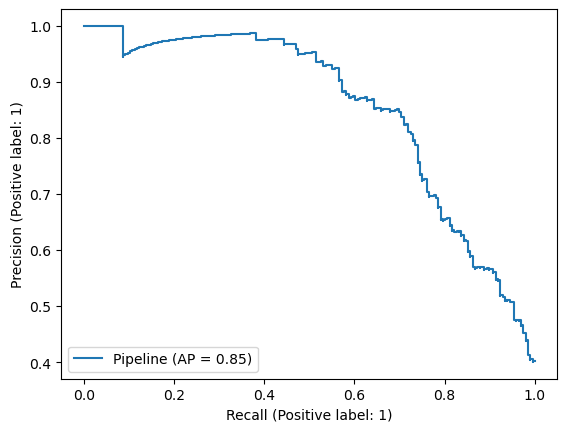

In [53]:
plot_precision_recall_curve(estimator=model_grid_pipeline, X=test_df["text"], y=test_df["target"])

In [54]:
id_col = df_test['id']
df_test = df_test.drop(['keyword', 'location', 'id'], axis = 1)

In [55]:
submission_test_pred = model_grid_pipeline.predict(df_test["text"])

In [56]:
submission_df = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred})

In [57]:
submission_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
